# Model-1 Face Recognition

## Verify Dependencies

In [2]:
import sys
import torch
import tensorflow as tf
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import pkg_resources

# Verify Python and library versions
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"facenet-pytorch version: {pkg_resources.get_distribution('facenet-pytorch').version}")

# Verify GPU availability
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

# Set up matplotlib for inline plotting
%matplotlib inline

print("Environment setup complete. Ready to proceed with data loading.")

Python version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.7.0+cu118
TensorFlow version: 2.10.0
OpenCV version: 4.11.0
NumPy version: 1.23.5
Matplotlib version: 3.10.3
facenet-pytorch version: 2.5.3
GPU available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Environment setup complete. Ready to proceed with data loading.


## Loading and Preparing the Custom Dataset

Label map: {0: 'Manika', 1: 'Rochan', 2: 'Sayali', 3: 'Shuchi'}
Number of classes: 4
Loaded 121 images for train split
Loaded 21 images for test split
Loaded 34 images for validate split


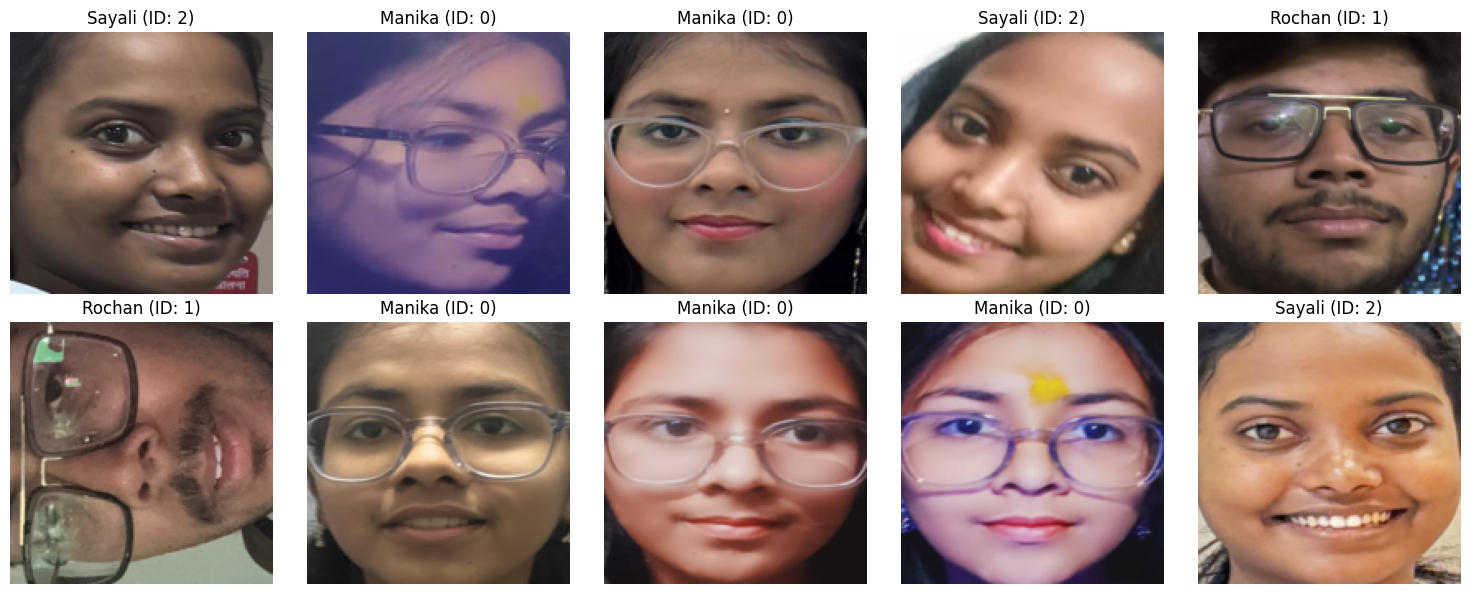

Dataset loading and preprocessing setup complete.


In [7]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import random

# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)

# Define dataset path
dataset_path = "C:/Users/Rochan/Desktop/Coding/Student_Surveillance/face_recognition/Data"

# Load labels.csv
labels_df = pd.read_csv(os.path.join(dataset_path, "labels.csv"))
label_map = dict(zip(labels_df["Id"], labels_df["Name"]))
num_classes = len(label_map)
print(f"Label map: {label_map}")
print(f"Number of classes: {num_classes}")

# Initialize MTCNN
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], 
              keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

# Custom Dataset class
class FaceDataset(Dataset):
    def __init__(self, data_dir, split, label_map, mtcnn):
        self.data_dir = os.path.join(data_dir, split)
        self.label_map = label_map
        self.mtcnn = mtcnn
        self.image_paths = []
        self.labels = []
        
        # Load image paths and labels
        for label_id in label_map.keys():
            label_dir = os.path.join(self.data_dir, str(label_id))
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.lower().endswith('.jpg'):
                        self.image_paths.append(os.path.join(label_dir, img_name))
                        self.labels.append(int(label_id))
        
        print(f"Loaded {len(self.image_paths)} images for {split} split")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        
        # Detect and crop face using MTCNN
        try:
            img_cropped = self.mtcnn(img)
            if img_cropped is None:
                raise ValueError("No face detected")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            # Return a blank image and skip (or handle differently)
            img_cropped = torch.zeros(3, 160, 160)
        
        return img_cropped, label

# Create datasets
train_dataset = FaceDataset(dataset_path, 'train', label_map, mtcnn)
test_dataset = FaceDataset(dataset_path, 'test', label_map, mtcnn)
validate_dataset = FaceDataset(dataset_path, 'validate', label_map, mtcnn)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Display 10 random sample images from the training dataset
num_samples = 10
sample_indices = random.sample(range(len(train_dataset)), num_samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    img, label = train_dataset[idx]
    # Rescale image from [-1, 1] to [0, 1] for visualization
    img = (img + 1) / 2
    img = img.clamp(0, 1)
    # Convert to HWC for plotting
    img = img.permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"{label_map[label]} (ID: {label})")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("Dataset loading and preprocessing setup complete.")